## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [2]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 10

# Prepare Training Data
1. Descárgate el dataset
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador.
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [3]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\data\\train\\"
TEST_PATH = ROOT_PATH + "\\data\\test\\"

In [4]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TRAIN_PATH)
filenames = os.listdir(TRAIN_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

In [5]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [6]:
df = df.sample(frac=1).reset_index(drop=True)

### See Total In count

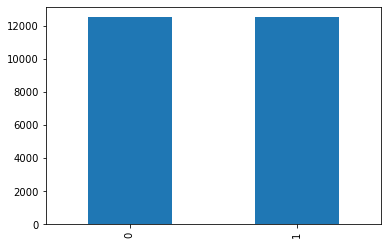

In [7]:
df['category'].value_counts().plot.bar();

# See sample image

(375, 499, 3)
255


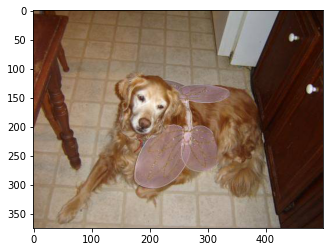

In [8]:
from skimage.io import imread
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [9]:
image

array([[[118, 101,  71],
        [118, 102,  69],
        [121, 101,  68],
        ...,
        [ 32,  11,   6],
        [ 32,  11,   6],
        [ 32,  11,   6]],

       [[122, 105,  75],
        [122, 105,  75],
        [126, 105,  74],
        ...,
        [ 32,  11,   6],
        [ 32,  11,   6],
        [ 32,  11,   6]],

       [[117, 100,  72],
        [119,  99,  72],
        [120,  99,  70],
        ...,
        [ 32,  11,   6],
        [ 32,  11,   6],
        [ 32,  11,   6]],

       ...,

       [[145, 127, 105],
        [145, 127, 105],
        [143, 125, 101],
        ...,
        [ 45,  20,  15],
        [ 45,  20,  15],
        [ 45,  20,  15]],

       [[144, 126, 104],
        [144, 126, 104],
        [144, 126, 102],
        ...,
        [ 44,  19,  14],
        [ 44,  19,  14],
        [ 44,  19,  14]],

       [[142, 124, 102],
        [143, 125, 103],
        [144, 126, 102],
        ...,
        [ 45,  20,  15],
        [ 45,  20,  15],
        [ 45,  20,  15]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (260, 339, 3)
Tamaño imagen reshape: (32, 32, 3)


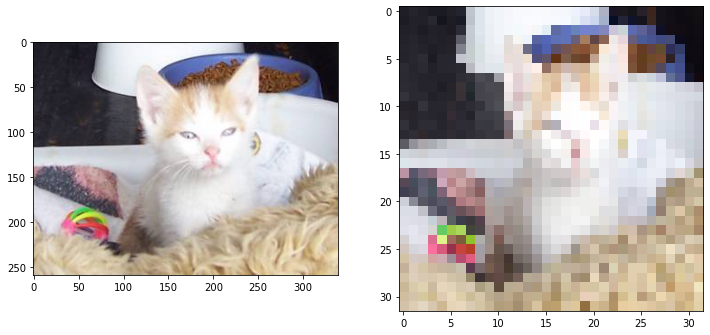

In [10]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Tamaño imagen original: (231, 284)


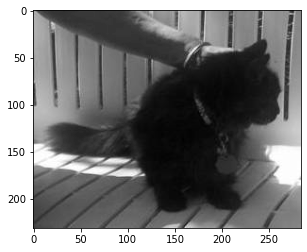

In [11]:
sample = random.choice(filenames)

image = cv2.imread(filename = TRAIN_PATH + sample, flags = cv2.IMREAD_GRAYSCALE)

print("Tamaño imagen original:", image.shape)
plt.imshow(image, cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [12]:
def read_data(path, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
        
        # Leer la imagen a color y aplicarle el resize
        image = imread(path + file)
        smallimage = cv2.resize(image, (im_size, im_size))
        
        # Guardo en X
        X.append(smallimage)
        
        category = file.split('.')[0]
        # Miro si es perro y gato para guardar en Y
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)
        

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
#X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH)

print(X_train.shape)
#print(X_test.shape)

(25000, 32, 32, 3)


(32, 32, 3)


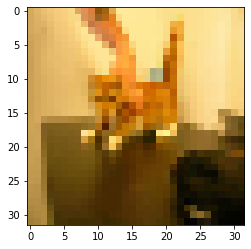

In [13]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [14]:
X_train[0]

array([[[210, 171,  93],
        [224, 181, 103],
        [235, 192, 114],
        ...,
        [254, 227, 157],
        [250, 218, 143],
        [245, 208, 127]],

       [[212, 168,  95],
        [221, 177, 102],
        [230, 186, 112],
        ...,
        [250, 231, 162],
        [250, 218, 143],
        [244, 215, 137]],

       [[212, 168,  95],
        [220, 176, 101],
        [222, 178, 104],
        ...,
        [249, 230, 161],
        [251, 219, 144],
        [249, 219, 147]],

       ...,

       [[173, 136,  65],
        [176, 139,  68],
        [173, 139,  65],
        ...,
        [ 10,  10,   2],
        [ 11,  11,   3],
        [  9,   9,   1]],

       [[166, 132,  61],
        [173, 136,  65],
        [174, 140,  68],
        ...,
        [  5,   6,   1],
        [  4,   5,   0],
        [  4,   5,   0]],

       [[158, 126,  58],
        [166, 131,  60],
        [173, 139,  67],
        ...,
        [  4,   4,   1],
        [  3,   3,   1],
        [  3,   3,   1]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [15]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [16]:
X_train = X_train / 255.0
#X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [17]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [18]:
X_train

array([[[[0.28235294, 0.17254902, 0.08627451],
         [0.29019608, 0.18431373, 0.09803922],
         [0.51764706, 0.50980392, 0.43921569],
         ...,
         [0.28235294, 0.29019608, 0.24313725],
         [0.21960784, 0.23137255, 0.20392157],
         [0.02352941, 0.02352941, 0.02352941]],

        [[0.31372549, 0.20784314, 0.12156863],
         [0.31372549, 0.2       , 0.11372549],
         [0.54509804, 0.54509804, 0.4745098 ],
         ...,
         [0.29803922, 0.29803922, 0.25098039],
         [0.20784314, 0.21568627, 0.17254902],
         [0.03137255, 0.03137255, 0.01960784]],

        [[0.36862745, 0.23529412, 0.12941176],
         [0.3254902 , 0.21176471, 0.1254902 ],
         [0.58431373, 0.58039216, 0.5372549 ],
         ...,
         [0.30588235, 0.30588235, 0.25882353],
         [0.27843137, 0.28627451, 0.24313725],
         [0.03529412, 0.03529412, 0.02352941]],

        ...,

        [[0.2627451 , 0.2       , 0.14901961],
         [0.23921569, 0.17254902, 0.13333333]

In [19]:
# Como Kaggle no tiene y_test, saco del train parte para el test

X_test = X_train[:int(np.floor(len(X_train)*0.2))]
y_test = y_train[:int(np.floor(len(y_train)*0.2))]

X_train = X_train[int(np.floor(len(X_train)*0.2)):]
y_train = y_train[int(np.floor(len(y_train)*0.2)):]

In [20]:
np.unique(y_test)

array([0, 1])

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [21]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

Para cargar

In [22]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [23]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [24]:
64*(3*3)*3+ 64

1792

In [25]:
#128*(3*3)*3

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               5

# Callbacks
#### Early Stopping

In [27]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [28]:
from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model.h5")

# Fit the model

In [29]:
set(y_test)

{0, 1}

In [30]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2,
         verbose=1)

Epoch 1/10
500/500 [==============================] - 41s 80ms/step - loss: 0.6200 - accuracy: 0.6474 - val_loss: 0.5319 - val_accuracy: 0.7500
Epoch 2/10
500/500 [==============================] - 42s 84ms/step - loss: 0.5202 - accuracy: 0.7426 - val_loss: 0.5111 - val_accuracy: 0.7442
Epoch 3/10
500/500 [==============================] - 40s 80ms/step - loss: 0.4712 - accuracy: 0.7761 - val_loss: 0.4823 - val_accuracy: 0.7695
Epoch 4/10
500/500 [==============================] - 40s 79ms/step - loss: 0.4206 - accuracy: 0.8076 - val_loss: 0.4499 - val_accuracy: 0.7865
Epoch 5/10
500/500 [==============================] - 41s 82ms/step - loss: 0.3866 - accuracy: 0.8245 - val_loss: 0.4407 - val_accuracy: 0.7968
Epoch 6/10
500/500 [==============================] - 41s 83ms/step - loss: 0.3434 - accuracy: 0.8471 - val_loss: 0.4544 - val_accuracy: 0.8000
Epoch 7/10
500/500 [==============================] - 41s 81ms/step - loss: 0.2973 - accuracy: 0.8721 - val_loss: 0.4650 - val_accuracy:

# Evaluate
Probemos los datos en el conjunto de test.

In [31]:
results = model.evaluate(X_test, y_test)
results

157/157 [==============================] - 4s 21ms/step - loss: 0.7091 - accuracy: 0.7670


[0.7090637683868408, 0.7670000195503235]

In [32]:
model.predict(X_test).round(0)

157/157 [==============================] - 3s 19ms/step


array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

157/157 [==============================] - 3s 20ms/step


array([[2221,  294],
       [ 871, 1614]], dtype=int64)

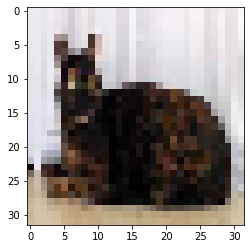

In [34]:
plt.imshow(X_test[-1]);

In [35]:
predictions = model.predict(X_test[-1:]).round(0)
predictions

1/1 [==============================] - 0s 34ms/step


array([[0.]], dtype=float32)

# Image data generator

In [36]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
0,cat.8510.jpg,cat
1,dog.10491.jpg,dog
2,dog.2481.jpg,dog
3,cat.8188.jpg,cat
4,dog.1868.jpg,dog


In [37]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

example_df = df.sample(n=1).reset_index(drop=True) # una foto
example_df

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = (128, 128)
)

Found 1 validated image filenames belonging to 1 classes.


In [38]:
example_df

,filename,category
0,dog.829.jpg,dog


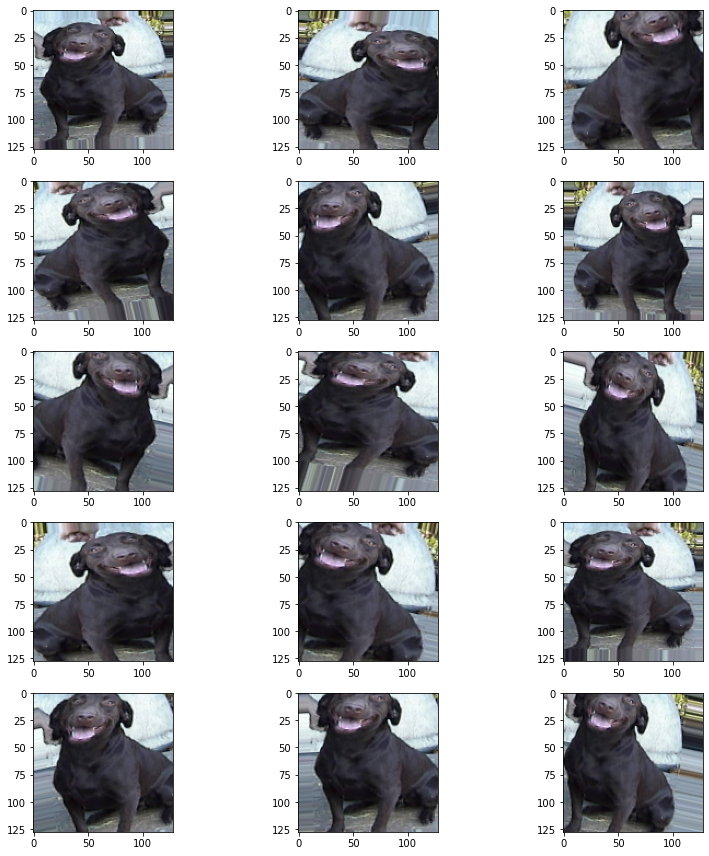

In [39]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Training Generator

In [40]:
# mirar desde AQUÍ xxxx

# saco el primer 20% ya barajado para ser test
df_test = df[:int(np.floor(0.2*len(df)))]
df_train = df[int(np.floor(0.2*len(df))):]


train_df, validate_df = train_test_split(df_train,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [41]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 16000
Shape validation 4000


,filename,category
0,cat.954.jpg,cat
1,cat.3775.jpg,cat
2,dog.11823.jpg,dog
3,cat.8762.jpg,cat
4,cat.4012.jpg,cat


In [42]:
train_df.head()

,filename,category
0,cat.7405.jpg,cat
1,dog.7727.jpg,dog
2,cat.5955.jpg,cat
3,cat.5807.jpg,cat
4,dog.7021.jpg,dog


In [43]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 16000 validated image filenames belonging to 2 classes.


### Validation Generator

In [44]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 4000 validated image filenames belonging to 2 classes.


# Fit Model

In [45]:
model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [46]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = validation_generator
)

Epoch 1/10
500/500 [==============================] - 113s 225ms/step - loss: 0.5058 - accuracy: 0.7531 - val_loss: 0.3947 - val_accuracy: 0.8192
Epoch 2/10
500/500 [==============================] - 109s 217ms/step - loss: 0.4676 - accuracy: 0.7780 - val_loss: 0.4995 - val_accuracy: 0.7440
Epoch 3/10
500/500 [==============================] - 108s 216ms/step - loss: 0.4629 - accuracy: 0.7778 - val_loss: 0.4141 - val_accuracy: 0.7985
Epoch 4/10
500/500 [==============================] - 109s 219ms/step - loss: 0.4503 - accuracy: 0.7875 - val_loss: 0.3550 - val_accuracy: 0.8457
Epoch 5/10
500/500 [==============================] - 110s 220ms/step - loss: 0.4398 - accuracy: 0.7929 - val_loss: 0.3814 - val_accuracy: 0.8235
Epoch 6/10
500/500 [==============================] - 108s 217ms/step - loss: 0.4373 - accuracy: 0.7924 - val_loss: 0.3650 - val_accuracy: 0.8290
Epoch 7/10
500/500 [==============================] - 109s 218ms/step - loss: 0.4370 - accuracy: 0.7936 - val_loss: 0.3885 -

In [47]:
##### CODE #####
'''

# Listar todos los archivos de la carpeta de train (TEST_PATH)
filenames = os.listdir(TEST_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')
    
    
test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
'''

"\n\n# Listar todos los archivos de la carpeta de train (TEST_PATH)\nfilenames = os.listdir(TEST_PATH)\n\n# Lista vacia\ncategories = []\n\n# Iterar\nfor filename in filenames:\n    # Saco el nombre\n    category = filename.split('.')[0]\n    \n    # If else\n    # Guardo en lista\n    if category == 'dog':\n        categories.append('dog')\n    else:\n        categories.append('cat')\n    \n    \ntest_df = pd.DataFrame({\n    'filename': filenames,\n    'category': categories\n})\n"

In [48]:
df_test#test_df

,filename,category
0,cat.8510.jpg,cat
1,dog.10491.jpg,dog
2,dog.2481.jpg,dog
3,cat.8188.jpg,cat
4,dog.1868.jpg,dog
...,...,...
4995,cat.11969.jpg,cat
4996,dog.7312.jpg,dog
4997,dog.1974.jpg,dog
4998,cat.6077.jpg,cat


In [49]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test, # era test_df 
    TRAIN_PATH, # era TEST_PATH
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [50]:
len(test_generator)

157

In [51]:
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

157/157 [==============================] - 19s 121ms/step - loss: 0.4162 - accuracy: 0.8022
test loss, test acc: [0.416196346282959, 0.8022000193595886]


In [52]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

157/157 [==============================] - 3s 20ms/step - loss: 0.4245 - accuracy: 0.7998
test loss, test acc: [0.42448124289512634, 0.7997999787330627]


# Virtualize Training

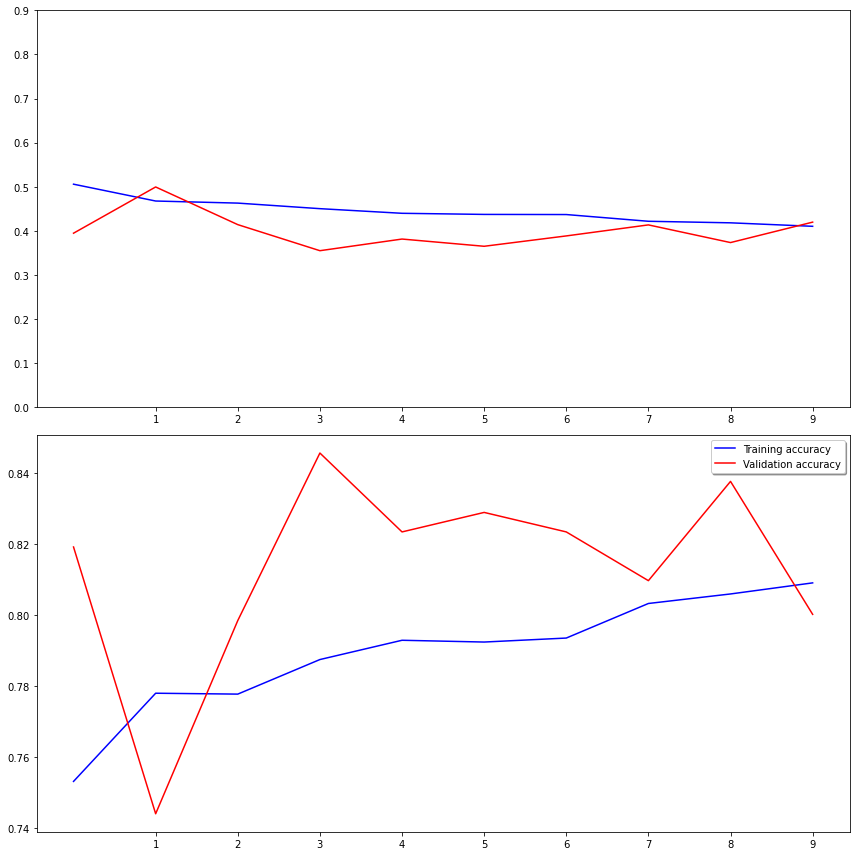

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()